In [1]:
#bibliotecas
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

from matplotlib import pyplot as plt

In [2]:
# Lendo dados;
train = pd.read_csv("../Databases/petr4_treinamento.csv")
test = pd.read_csv("../Databases/petr4_teste.csv")

### Pre-processamento

In [3]:
# Retirando valoes vazios;
train = train.dropna()

# Separando o que queremos prever;
y_train = train.iloc[: , 1:2].values

# Preparando para normalizar o y_train;
normalizador = MinMaxScaler(feature_range=(0,1))
y_train = normalizador.fit_transform(y_train)


In [4]:
# Preparando, será usado 90;
to_pred = []
data_real = []

for i in range(90, 1242):
    to_pred.append(y_train[i-90:i, 0])
    data_real.append(y_train[i, 0])

pred, real = np.array(to_pred), np.array(data_real)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1], 1))

del to_pred, data_real

### Criando camadas da rede neural

In [5]:
def createNetwork():
    model = Sequential()
    # camada de entrada
    model.add(LSTM(units=100, return_sequences=True, input_shape = (pred.shape[1], 1)))
    model.add(Dropout(0.3))
    # Camada oculta 01;
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 02;
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 03;
    model.add(LSTM(units=80))
    model.add(Dropout(0.3))

    # Camada de saída;
    model.add(Dense(units=1, activation='linear'))

    # Configurando compile;
    model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mean_squared_error"])

    return model

In [6]:
# Treinando modelo
regressor = createNetwork()

regressor.fit(pred, real, epochs=200, batch_size= 64 )

============] - 4s 207ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 24/200
18/18 [==============================] - 4s 210ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 25/200
18/18 [==============================] - 4s 203ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 26/200
18/18 [==============================] - 4s 214ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 27/200
18/18 [==============================] - 4s 217ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 28/200
18/18 [==============================] - 4s 216ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 29/200
18/18 [==============================] - 4s 217ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 30/200
18/18 [==============================] - 4s 225ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 31/200
18/18 [==============================] - 4s 227ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 32/200
18/18 [==========

### Trabalhando com dados de teste

In [7]:
# Cocatenando dados de test e treino;
base = pd.concat((train["Open"], test["Open"]), axis=0)

# Fazendo split dos dados;
test = test.iloc[:, 1:2].values

# Ajustando a qunatidade necessaria de dasos para prever um mês;
base = base[len(base) - len(test) - 90:].values

# Realizando mudança de dimensionalidade;
base = base.reshape(-1,1)
# Normalizando dados;
base = normalizador.transform(base)


In [8]:
# Fazendo divisão de amostra com tamanho 90;
X_test = []
for i in range(90, 112):
    X_test.append(base[i-90:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_test = regressor.predict(X_test)
pred_test = normalizador.inverse_transform(pred_test)

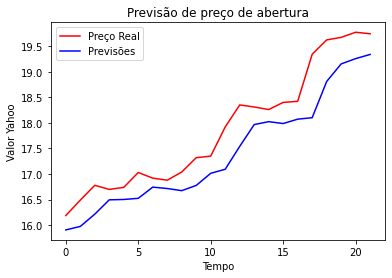

In [9]:
# Criando Grafico;
plt.plot(test, color="red", label="Preço Real" )
plt.plot(pred_test, color="blue", label="Previsões")
plt.title("Previsão de preço de abertura")
plt.xlabel("Tempo")
plt.ylabel("Valor Yahoo")
plt.legend()
plt.show();

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base = pd.read_csv('../Databases/petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:2].values

normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

base_teste = pd.read_csv('petr4_teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)

previsoes.mean()
preco_real_teste.mean()
    
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()


























